<a href="https://colab.research.google.com/github/jennifer-holm/snapgraze/blob/main/snapgraze_v1_1_NG1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running project scenario...

--- Model Results ---
          Variable       Value
0                G   98.694589
1               D1    3.084206
2                E   23.131544
3               F1   46.263088
4               F2   23.131544
5               F3    0.000000
6               F4    0.000000
7          ANPPmax  405.449248
8            ANPPg  235.568324
9            BNPPg   91.507352
10              RS    0.388454
11           fBNPP    0.279774
12      GI_outcome    0.418994
13  residence_time  128.801308
14           MRESP   71.226157
15             SOC   54.700000
16           SOCeq   91.740221
17        SOC_proj   64.588280
18       dSOC_proj    0.247207

--- Projected SOC per year ---
[54.94720701 55.19441402 55.44162103 55.68882804 55.93603504 56.18324205
 56.43044906 56.67765607 56.92486308 57.17207009 57.4192771  57.66648411
 57.91369112 58.16089812 58.40810513 58.65531214 58.90251915 59.14972616
 59.39693317 59.64414018 59.89134719 60.1385542  60.3857612  60.63296821
 60.8

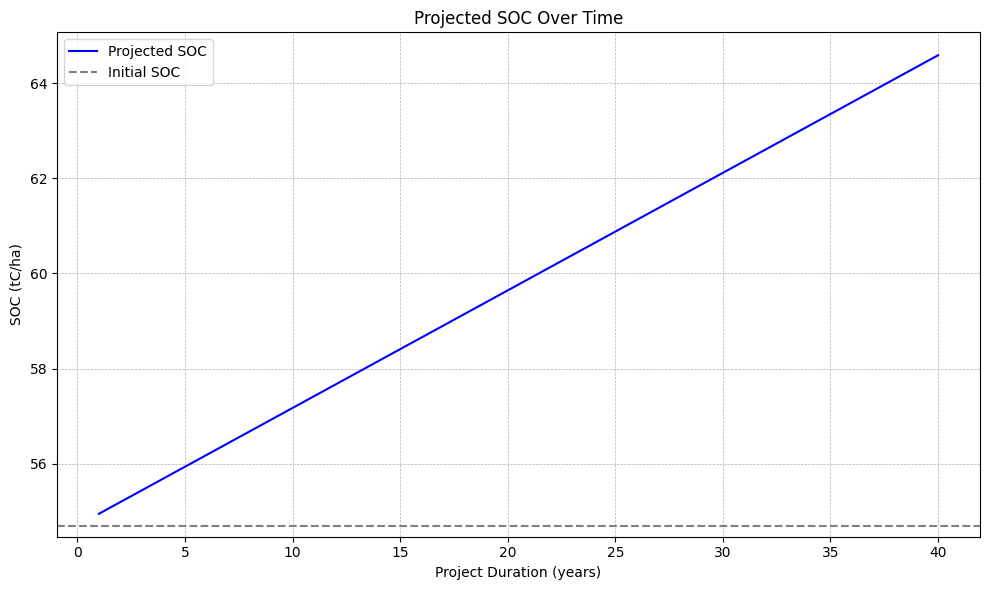

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Python Script: Replicating SNAPGRAZE Model
# R's rm(list = ls()) is not needed in Python as scripts run in a clean environment.

# User Defined Input Parameters (NG1 data)
MAT = 21.08        # Mean Annual Temperature (°C)
MAP = 445          # Mean Annual Precipitation (mm)
SAND = 62.7        # Soil Sand Content (%)
SOC = 54.70        # Initial Soil Organic Carbon (tC/ha)
FIRE = 0           # Fire intensity (assumed as 0)
LIGCELL = 42.32    # Lignin cellulose (%)
area = 1775        # Total Area (ha)
animals = 180      # Number of Animals
weight = 400       # Average Weight of Animals (kg)
paddocks = 16      # Number of Paddocks
depth = 19.89      # Soil Depth (cm)
project_duration = 40  # Duration of the project (years)
rotate = 2         # Number of rotations within a plant growing season (#)
scenario = "Project" # "Baseline" vs. "Project". If Baseline, also need to make paddocks = 1

# Constant Input Parameters
k = 0.00044        # Decomposition rate
ANPPmax_b = 12.039 # Maximum Aboveground Net Primary Productivity (gDM/m²/year) Default value from paper
WETDAYS_m = 0.00044# Moisture availability (days/mm) Default value from paper
APC = 1.00         # Aboveground Plant Carbon
rmax = 0.032       # Maximum growth rate

# Grazing Days Calculation
G = (22.99 * MAT) - (0.94198 * MAT**2) + (0.07337 * MAP)

# Initialize variables that might only be defined in one branch of the if/else
D2, D3, D4, F2, F3, F4 = 0, 0, 0, 0, 0, 0

if scenario == "Baseline":
    print("Running baseline scenario...")
    D1 = G / paddocks
    E = (G - rotate * D1) / 2
    F1 = (G - rotate * D1) / 2
    Days_check = D1 + E + F1
else:
    print("Running project scenario...")
    D1 = G / (paddocks * rotate)
    D2 = D1 if rotate == 2 else 0
    D3 = D1 if rotate == 3 else 0
    D4 = D1 if rotate == 4 else 0
    E = (G - rotate * D1) / (2 * rotate)

    # F for projects, depending on rotations
    F1 = E * 2 if rotate >= 2 else E

    if rotate == 2:
        F2 = F1 / rotate
    elif rotate >= 3:
        F2 = F1
    else:
        F2 = 0

    if rotate == 3:
        F3 = E
    elif rotate > 3:
        F3 = E * 2
    else:
        F3 = 0

    F4 = G - E - D1 - F1 - D2 - F2 - D3 - F3 - D4 if rotate >= 4 else 0
    Days_check = D1 + D2 + D3 + D4 + E + F1 + F2 + F3 + F4

# Biomass Productivity Calculation
ANPPmax = max(0, (math.exp(ANPPmax_b + 0.718 * math.log(MAP) - (25.18 / (0.00834 * (273.15 + MAT)))) * (1.33 - 0.0075 * SAND)))

# Biomass Stock Calculations
Sk = max(0, ANPPmax)
S0 = max(0, 0.1 * Sk)

# WETDAYS Calculation (days)
WETDAYS = (WETDAYS_m * MAP - 0.025) * G

# Consumption and Biomass Loss Calculations
Cg = 2 * (5300 + 770 * math.log(weight))
SD = animals / area
Lg = max(0, D1 * Cg * paddocks * SD / 10000)
Lo = max(0, (Cg / 2) * (365 - G) * SD / 10000)

# Biomass Stock Progression
Se = max(0, (S0 * Sk) / (Sk * math.exp(-rmax * E) + S0 * (1 - math.exp(-rmax * E))))
pploss = (Cg * (animals / area) * paddocks) / (Se * 10000) if Se > 0 else 0
Sg = max(0, (Se * Sk) / (Sk * math.exp(-(rmax - pploss) * D1) + Se * (1 - math.exp(-(rmax - pploss) * D1))))
Se2 = max(0, (Sk * Sg) / (Sk * math.exp(-rmax * F1) + Sg * (1 - math.exp(-rmax * F1))))
Sg2 = max(0, (Sk * Se2) / (Sk * math.exp(-(rmax - pploss) * D2) + Se2 * (1 - math.exp(-(rmax - pploss) * D2))))
Se3 = max(0, (Sk * Sg2) / (Sk * math.exp(-rmax * F2) + Sg2 * (1 - math.exp(-rmax * F2))))
Sg3 = max(0, (Sk * Se3) / (Sk * math.exp(-(rmax - pploss) * D3) + Se3 * (1 - math.exp(-(rmax - pploss) * D3))))
Se4 = max(0, (Sk * Sg3) / (Sk * math.exp(-rmax * F3) + Sg3 * (1 - math.exp(-rmax * F3))))
Sg4 = max(0, (Sk * Se4) / (Sk * math.exp(-(rmax - pploss) * D4) + Se4 * (1 - math.exp(-(rmax - pploss) * D4))))
Sf = max(0, (Sk * Sg4) / (Sk * math.exp(-rmax * F4) + Sg4 * (1 - math.exp(-rmax * F4))))

# Productivity Calculations
ANPPg = max(0, Sf - S0 if Sg > Se else (Se - S0) + (Se2 - Sg) + (Se3 - Sg2) + (Se4 - Sg3) + (Sf - Sg4))
BNPPg = max(0, (0.602 * MAP - 0.00038 * MAP**2 + 5.887 * MAT) * (ANPPg / ANPPmax) * APC * (depth / 40)) if ANPPmax > 0 else 0
RS = (BNPPg / ANPPg) if (BNPPg != 0 and ANPPg != 0) else 0
fBNPP = RS / (1 + RS)
GI_outcome = 1 - ANPPg / ANPPmax if ANPPmax > 0 else 0
GI_consumption = (Lg + Lo) / ANPPg if ANPPg > 0 else 0

# Additional Calculations
PDSOC = max(0, 0.45 * ((LIGCELL/100) * (Sf - Lo/2) * (1 - FIRE) + (LIGCELL/100 + 0.05) * BNPPg))
DDSOC = max(0, (LIGCELL/100) * 0.45 * 0.3 * ((Lg/D1) * (D1+D2+D3+D4) + Lo)) if D1 > 0 else 0

# SOC Equilibrium Calculations (tC/ha)
SOCeq_lin = ((PDSOC + DDSOC) / (k * WETDAYS * (0.7 + 0.3 * SAND/100)) + (0.579/k)) * (10000/1000000) * (-0.35 + 0.37 * math.log(depth))
SOCeq_exp = (10000/1000000) * (-0.35 + 0.37 * math.log(depth)) * ((PDSOC + DDSOC) / (WETDAYS * (0.7 + 0.3 * SAND/100) * math.exp(-10.872)))**(1/1.296)
SOCeq = min(SOCeq_lin, SOCeq_exp)

# DM Respiration Calculations (gC/m2/d)
DMRESPexp = math.exp(-10.872) * (((SOCeq * 1000000 / 10000) / (-0.35 + 0.37 * math.log(depth))))**1.296
DMRESPlin = k * SOCeq * (1000000 / 10000) / (-0.35 + 0.37 * math.log(depth)) - 0.579
DMRESP = max(DMRESPexp, DMRESPlin)

# MRESP Calculation (gC/m2/yr)
MRESP = WETDAYS * (0.7 + 0.3 * SAND/100) * DMRESP

# Residence Time Calculation (years)
residence_time = (SOCeq * 1000000 / 10000) / MRESP if MRESP > 0 else float('inf')

# SOC Projection Calculation (tC/ha)
# Handle case where residence_time might be zero or infinity to avoid math errors
if residence_time > 0 and not math.isinf(residence_time):
    SOC_proj = SOC + (SOCeq - SOC) * (1 - math.exp(-project_duration / residence_time))
else:
    SOC_proj = SOC # If residence time is 0 or infinite, no change occurs this way

dSOC_proj = (SOC_proj - SOC) / project_duration
dSOC_eq = (PDSOC + DDSOC - MRESP)

# Unit conversion (tCO2e/ha/yr) - kept as comments to match R script
# SOC_proj = SOC_proj * (44/12)
# dSOC_proj = dSOC_proj * (44/12)

# --- Output Results ---
# Creating a dictionary to hold the results
results_dict = {
    "Variable": ["G", "D1", "E", "F1", "F2", "F3", "F4", "ANPPmax", "ANPPg", "BNPPg", "RS", "fBNPP", "GI_outcome", "residence_time", "MRESP", "SOC", "SOCeq", "SOC_proj", "dSOC_proj"],
    "Value": [G, D1, E, F1, F2, F3, F4, ANPPmax, ANPPg, BNPPg, RS, fBNPP, GI_outcome, residence_time, MRESP, SOC, SOCeq, SOC_proj, dSOC_proj]
}

# Converting the dictionary to a pandas DataFrame for a nice printable table
results_df = pd.DataFrame(results_dict)

print("\n--- Model Results ---")
print(results_df)

# --- Plotting Section ---
# Create time vector (years)
years = np.arange(1, project_duration + 1)

# Calculate the cumulative SOC for each year
# The R script calculates a constant annual change (dSOC_proj) and applies it cumulatively.
# We can do this efficiently using numpy.
SOC_cumulative = SOC + years * dSOC_proj

# Create the plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(years, SOC_cumulative, color="blue", linewidth=1.5, label="Projected SOC")
plt.axhline(y=SOC, linestyle="--", color="gray", label="Initial SOC")

# Adding titles and labels
plt.title("Projected SOC Over Time")
plt.xlabel("Project Duration (years)")
plt.ylabel("SOC (tC/ha)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()
